# Reverse perturbation tutorial
## Tutorial 2: Multiple particle collision dynamics 

Make sure that hoomd-blue and azplugins are installed correctly. For more details see Tutorial 0. This tutorial builds upon the LJ fluid tutorial for the reverse perturbation method, **please read it first**. In this tutorial, we will use the azplugins implementation of the [reverse perturbation method](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.59.4894) by M&uuml;ller-Plathe to generate shear flow in a simple multi-particle collision dynamics (MPCD) fluid. 

 ### System setup

First, we need to set up a simple MPCD simulation:

```Python
import numpy as np
import sys
import hoomd
from hoomd import md
from hoomd import data
from hoomd import azplugins
from hoomd.azplugins import mpcd

L = 10
kT = 1.0
rho_mpcd = 5
viscosity_mpcd = 3.955

hoomd.context.initialize()
hoomd.context.SimulationContext()

snapshot = hoomd.data.make_snapshot(N=0,box=data.boxdim(L=L))
system = hoomd.init.read_snapshot(snapshot)

N_mpcd = int(rho_mpcd*system.box.get_volume())
snap = hoomd.mpcd.data.make_snapshot(N=N_mpcd)

snap.particles.position[:] = np.random.uniform(-L/2.0, L/2.0, (N_mpcd,3))
snap.particles.velocity[:] = np.random.normal(0, np.sqrt(kT), (N_mpcd,3))
snap.particles.velocity[:] -= np.average(snap.particles.velocity,axis=0)

mpcd_sys = hoomd.mpcd.init.read_snapshot(snap)
```


We want to set up a simulation at a reduced temperature of $k_\text{B}T=1.0$ and at a number density of $\rho_\text{mpcd}=5$ in a cubic box with $L = 10$. Both positions and velocities are set up randomly in the box. If you have an idea what flow field to expect, you can make equilibration faster by modifying the velocities accordingly. MPCD kinematic viscosities can be calculated from (see this [publication](https://journals.aps.org/pre/pdf/10.1103/PhysRevE.72.016701)): 

$\eta = \eta_\text{coll} +\eta_\text{kin}$

$\frac{\eta_\text{coll}}{\sqrt{k_\text{B}T a^2/m}} =  \frac{1}{\lambda}\frac{1-\cos{\alpha}}{18}\left(1 -\frac{1}{\rho_\text{mpcd}}\right) $

$\frac{\eta_\text{coll}}{\sqrt{k_\text{B}T a^2/m}} = \lambda\left(\frac{1}{(4-2\cos{\alpha}-2\cos{2\alpha})} \frac{5\rho_\text{mpcd}}{\rho_\text{mpcd}-1} -\frac{1}{2}\right) $

where $m=1$ is the mass of each particle, $a=1$ is the grid size, $\alpha$ is the collision angle, and $\lambda$ is the timestep, defined later. We use the same class than before to measure fluid properties:

```Python
class measure_fluid_properties:
    def __init__(self, system, binsize, L):
        self.system   = system
        self.binsize  = binsize
        self.num_bins = np.round(L/self.binsize).astype(int)
        self.H_vx     = np.zeros(self.num_bins)
        self.H_dens   = np.zeros(self.num_bins)
        self.counter  = 0
        self.range    = [-L/2.,L/2.]

    def __call__(self, timestep):
        hoomd.util.quiet_status()
        snap = self.system.take_snapshot()
        hoomd.util.unquiet_status()
        pos = snap.particles.position
        vel = snap.particles.velocity
        # pick z coordinates
        pos_z = pos[:,2]
        H_dens, edges = np.histogram(pos_z,bins = self.num_bins,range=self.range)
        H_vx, edges   = np.histogram(pos_z,weights=vel[:,0], bins = self.num_bins,range=self.range)

        self.H_dens  += H_dens
        self.H_vx    += H_vx

        if self.counter==100:
            to_save_Hvx = np.divide(self.H_vx, self.H_dens, out=np.zeros_like(self.H_vx), where=self.H_dens!=0)
            centers  =  (edges[:-1] + edges[1:])/2
            np.savetxt('tutorial_reverse_perturbation_2_mpcd_vx.hist',np.c_[centers,to_save_Hvx], header="z, v_x")
            self.counter  = 0
        else:
            self.counter += 1

```

### Eqilibration 

For the tutorial I just quickly "equilibrated" the system for 10,000 timesteps with  stochastic rotation dynamics (SRD) with an angle $\alpha=$``angle=130`` at a timestep of $\lambda$=``dt=0.1``. For a real simulation you will probably want to equilibrate your system properly before starting the shear flow. More information about the MPCD algorithm and how to couple MPCD fluids to MD particles can be found in the [hoomd-blue doumentation](https://hoomd-blue.readthedocs.io/en/stable/package-mpcd.html).

```Python
hoomd.mpcd.integrator(dt=0.1)
mpcd_sys.sorter.set_period(25)
srd   = hoomd.mpcd.collide.srd(seed=512, period=1, angle=130., kT=kT)
bulk  = hoomd.mpcd.stream.bulk(period=1)

hoomd.run(1e5)
```

### Measuring quantities during the non-equilibrium simulation 

```Python
o = measure_fluid_properties(mpcd_system, binsize=0.1, L=L)
analyze =  hoomd.analyze.callback(o, period=1e2)
log = hoomd.analyze.log(filename="tutorial_reverse_perturbation_2_mpcd.log",
                        quantities=['rp_momentum'],
                        period=1e2,overwrite=True)
```

The main difference between the LJ reverse perturbation and the MPCD reverse perturbation is a slight change in the function and its arguments. No group argment is needed, but all the other parameters are the same:

```Python
f = azplugins.mpcd.reverse_perturbation(width=1,Nswap=1,period=1,target_momentum=0.5)
```

### Run the non-equilibrium simulation 

```Python
hoomd.run(1e6)

snap = mpcd_sys.take_snapshot()
pos  = snap.particles.position
vel  = snap.particles.velocity
np.save('tutorial_reverse_perturbation_2_mpcd_pos.npy',pos)
np.save('tutorial_reverse_perturbation_2_mpcd_vel.npy',vel)
```

### azplugins.flow.reverse_perturbation parameters  

Please see the LJ tutorial for a detailed description of the parameters. **Note:** for MPCD, the speed of sound should be the upper limit for velocites, so it is advisable to not exceed $v_\text{max}=0.5$ in the desired flow field. Because the viscosity is known, $v_\text{max}$ can be computed from the target Reynolds number $Re$: $v_\text{max} = 2\eta_\text{mpcd}Re/(\rho_\text{mpcd}L_z)$. You can also estimate $v_\text{max}$ from the known viscosity and the reverse_perturbation parameters:

$v_\text{max} = \frac{\text{target_momentum}\cdot N_\text{swap}/\text{period}}{L_xL_y\lambda\eta_\text{mpcd}} \frac{L_z}{4}$

This can also be useful to estimate the parameters for the reverse perturbation based on a desired Reynolds number or for setting up the velocity profile close to the expected shape at the beginning of the simulation. 

### Analyzing the results
For MPCD it is often impractical to write actual snapshots of the system. We save our configuration at the end in numpy arrays for restarting purposes, which can be read in instead of random positions/velocities. 

Check the $v_x(z)$ histogram we recorded to see what the velocity gradient in the system is: 

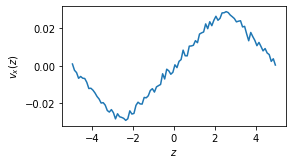

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# reading the recorded velocity profile
velocity_profile = np.genfromtxt('tutorial_reverse_perturbation_2_mpcd_vx.hist', skip_header=True)
# plotting the velocity profile
plt.figure(figsize=(4,2.2))
plt.plot(velocity_profile[:,0], velocity_profile[:,1])
plt.xlabel('$z$')
plt.ylabel('$v_x(z)$')
plt.show()

You should see a triangular shaped flow profile, with a maximum of $\approx 0.07$ in the upper exchange region at $L_z/4=10/4=2.5$ and a minimum of $\approx -0.07$ in the lower exchange region at $-2.5$.  The slope of the linear parts in the velocity profile is the shear rate. 

This method of generating shear has a upper limit as well as a lower limit for the shear rate. The upper limit is most likely given by the mpcd fluid ($v_\text{max}=0.5$), not by the reverse perturbation. The maxima/minima agree what would be estimated by the equations above.

We can also check what momentum we exchange during the simulation:

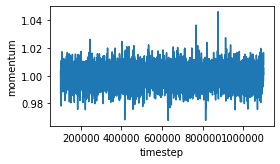

In [17]:
# reading momentum exchange
data = np.genfromtxt('tutorial_reverse_perturbation_2_mpcd.log', skip_header=True)

# plotting 
plt.figure(figsize=(4,2.2))
# skipping first entry, because that one will be zero in any case
plt.plot(data[1:,0], data[1:,1])
plt.xlabel('timestep')
plt.ylabel('momentum')
plt.show()

Because we used `Nswap=1` and `target_momentum=0.5`, each time the plugin is executed it exchanges momentum of roughly 1.You can see that with the chosen parameters we get a nice constant momentum swap during the entire simulation run.  Note that the sum of `data[1:,2]` does not give the total exchanged momentum, because we only recorded every `period=1e2` timesteps. 

 ### Viscosity calculation

Now, the viscosity $\mu$ in linear shear flow is simply the constant between the shear rate $\dot \gamma$ and stress $\tau$, 
\begin{align}
\tau = \mu \dot \gamma \quad \text{or}\quad \mu = \frac{\tau}{\dot \gamma}
\end{align}
Meaning, that if we can determine both shear rate $\dot \gamma$ and stress $\tau$ from our simulation, we can easily calculate the viscosity!
The shear stress in this method is given by:
\begin{align}
\tau = \frac{\langle \Delta p_x\rangle}{2L_xL_y\Delta t}
\end{align}
where $\langle \Delta p_x\rangle$  denotes the average amount of momentum exchanged during the interval $\Delta t$. The original publication uses the total exchanged momentum during the whole simulation time. Because we do not want to write to file that frequently and record large files, we record less frequently and use the average instead. In the end, for a well behaved steady-state simulation this should be identical. The shear rate $\dot \gamma$ can be extracted from the linear part of velocity profile with a linear fit:

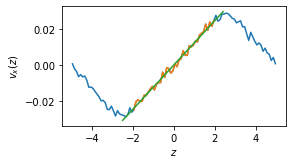

In [18]:
L = 10
w = 1

linear_part = velocity_profile[np.abs(velocity_profile[:,0])<L/4. - w/2.]
plt.figure(figsize=(4,2.2))
plt.plot(velocity_profile[:,0], velocity_profile[:,1])
plt.plot(linear_part[:,0], linear_part[:,1])

gamma_dot,b = np.polyfit(linear_part[:,0], linear_part[:,1], 1)
a = np.arange(-L/4.,L/4.,0.1)
plt.plot(a, gamma_dot*a+b)
plt.xlabel('$z$')
plt.ylabel('$v_x(z)$')
plt.show()

You can fit both linear parts, or fit a full triangle to increase accuracy, or numerically determine the derivative, as shown below. It is important to exclude the exchange regions regardless of method used, because the velocity profile is usually not linear inside the exchange regions. 

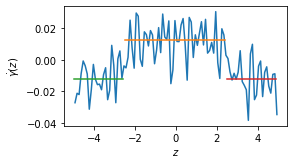

In [19]:
plt.figure(figsize=(4,2.2))
dx = velocity_profile[1,0]-velocity_profile[0,0]
grad = np.gradient(velocity_profile[:,1],dx)
plt.plot(velocity_profile[:,0], grad)
b = np.arange(-L/2.,-L/4.,0.1)
c = np.arange(L/4.,L/2.,0.1)
plt.plot(a, gamma_dot*np.ones(len(a)))
plt.plot(b, -gamma_dot*np.ones(len(b)))
plt.plot(c, -gamma_dot*np.ones(len(c)))

plt.xlabel('$z$')
plt.ylabel('$\dot \gamma(z)$')
plt.show()

We exchanged a momentum of roughly 1 every 1 timesteps, so 1 per $0.1$ time, since the timestep during the simulation was `dt=0.01`. We can check by calculating the average, which should be close to 1. Then, we simply have to divide $\tau$ by $\dot \gamma$:

In [22]:
# skipping first entry, because that one will be zero in any case
mom_av = np.average(data[1:,1])
tau = mom_av/(2*L*L*0.1)
viscosity = tau/gamma_dot
print(viscosity)

4.043122529924922


We get a value very close to the predicted 3.955. 

We have observed unexpected secondary flows in elongated boxes (see this [publication](https://arxiv.org/pdf/1811.04097.pdf) for details), so it is worthwhile to carefully check for box size effects.
You should test the smalles and biggest dimensions you are intending to use in your simulations. 

Also vary the parameters of the reverse perturbation to check for systematic effects. Sweep a reasonable set of shear rates to determine the upper and lower limit of the acsessible linear response regime. 



### Future reading:

- Original publication: Florian Mueller-Plathe. Reversing the perturbation innonequilibrium
    molecular dynamics:  An easy way to calculate the shear viscosity of
    fluids. Phys. Rev. E, 59:4894-4898, May 1999.
    <http://dx.doi.org/10.1103/PhysRevE.59.4894>
- Follow-up publications, describe the algorithm in more detail: 
    * Müller-Plathe, F., & Bordat, P. (2004). Reverse Non-equilibrium Molecular Dynamics. Lecture Notes in Physics, 310–326. <http://dx.doi.org/10.1007/978-3-540-39895-0_10>
    * Müller-Plathe, F., & Reith, D. (1999). Cause and effect reversed in non-equilibrium molecular dynamics: an easy route to transport coefficients. Computational and Theoretical Polymer Science, 9(3-4), 203–209. <http://dx.doi.org/10.1016/s1089-3156(99)00006-9>
- Our own publications about the method, describe some of the observed problems of the algorithm: 
    * Instability of Shear Flows in Spatially Periodic Domains, MP Howard, A Statt, HA Stone, TM Truskett, arXiv preprint arXiv:1907.07086 <https://arxiv.org/pdf/1907.07086.pdf>
    * Unexpected secondary flows in reverse nonequilibrium shear flow simulations, A Statt, MP Howard, AZ Panagiotopoulos, Physical Review Fluids 4 (4), 043905 <https://arxiv.org/pdf/1811.04097.pdf>
- This is the documentation page of the lammps implementation of the same algorithm: https://lammps.sandia.gov/doc/fix_viscosity.html Comparing against a different simulation package can be a useful exercise for finding bugs.


